Import some possible required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.interpolate import interp2d, LinearNDInterpolator
import movies_from_plots as mfp
import selfpropelledparticlevoronoi as sppv
import pathlib
from scipy import ndimage as nd 
import h5py as h5
import importlib

In [2]:
importlib.reload(mfp)
importlib.reload(sppv)

<module 'selfpropelledparticlevoronoi' from '/home/rafael/Documents/tissuewoundmodelling-main/SpringNetworkSimul/selfpropelledparticlevoronoi.py'>

We can make a regular (crystalline) lattice by following a "Bravais lattice" - like approach, where the lattice is a set of translations of points in 2D,

$R =  \sum_{i}{n_i \vec{a}_i} $

Where $n_i$ is an integer and $a_i$ is a basis vector of the lattice space. Our approach is slightly different, as we use nonintegers, that can be represented as 

$$ R = A \vec{u} $$

Where the columns of $A$ correspond to our basis vectors, and $\vec{u}$ is a vector of coordinates such that 

$u_i = n_i \Delta x$ 

where $\Delta x$ is the interval between the points such that all grid elements are equally spaced.

In [7]:
importlib.reload(mfp)
importlib.reload(sppv)

if True:
    # Define a random lattice

    N = int(input("Square root of the number of points you want to add onto the network"))**2

    L_max = 5
    L_min = -5

    x_coord = (L_max-L_min)*(np.random.rand(N)) + L_min
    y_coord = (L_max-L_min)*(np.random.rand(N)) + L_min

    coords = np.array((x_coord,y_coord)).T

vor = Voronoi(coords)

# Define arrays to insert numerical results

M = 5000
coords_evo = np.zeros((N,2,M))
coords_evo_vertex = np.zeros((len(vor.vertices),2,M))
coords_evo[:,:,0] = coords
coords_evo_vertex[:,:,0] = vor.vertices

coords_evo_v = np.zeros((N,2,M))
coords_evo_vertex_v = np.zeros((len(vor.vertices),2,M))

dt = 1*1e-3
DeltaL = L_max - L_min
r0 = min(DeltaL/(3*np.sqrt(N)),0.5)

vor_ridges = sppv.remove_minus(vor.ridge_vertices)

Force_center_vector = np.zeros((N,2,M))
Force_vertex_vector = np.zeros((len(vor.vertices),2,M))

vor_ridges_array = np.zeros((len(vor_ridges),2,M))
vor_ridges_array[:,:,0] = vor_ridges

vor_point_region = vor.point_region
vor_regions = vor.regions

vor_regions_array = []
vor_regions_array.append(vor_regions)

boundary = sppv.find_boundary_vertices(len(vor.vertices),vor_ridges)

A model for T1 transition might possibly be:

Consider a graph with regions $R = \{R_\mu\}$, vertices $V = \{v_i\}$, and edges $E = \{(v_i,v_j)| v_i, v_j \in V\}$ where a region $R_\mu = \{(v_i,c_\mu)|v_i \in V\}$ for a center $c_\mu$

for 2 vertices $A$ and $B$, if their distance $|\vec{AB}|$ is less than or equal to a threshold value, they change their coordinate positions to: 

$$
(A',B') = \frac{\sqrt{3}}{2}(R_{\pm \pi/2}\vec{AB}+1/2\vec{AB}) +\vec{A}
$$

The transition can be modelled in two different ways:

1 - We describe a simple discrete model where 

$$
P[(A,B)\rightarrow(A',B')]=
\begin{cases}
0, & \text{for } |\vec{AB}| > l_\text{thresh}\\
1,  & \text{for } |\vec{AB}| \leq l_\text{thresh}
\end{cases}
$$

2 - Or we can follow a more continuous, physically inspired approach, where:

$$
P[(A,B)\rightarrow(A',B')] \propto \exp{(-\beta k |\vec{AB}|²)}
$$

3 - A mixed approach could be helpful to ensure the transition occurs at a reasonable rate.

$$
P[(A,B)\rightarrow(A',B')]=
\begin{cases}
0, & \text{for } |\vec{AB}| > l_\text{thresh}\\
\exp{(-\beta k |\vec{AB}|²)},  & \text{for } |\vec{AB}| \leq l_\text{thresh}
\end{cases}
$$

Where $\beta$ is meant to represent thermal energy, or some energy coefficient threshold. 

If we impose the criteria that 

$P[(A,B)\rightarrow(A',B')| \leq l_\text{thresh}] \geq  0.5$ 

we have the following inequality:

$$\beta \leq  \frac{\ln(2)}{k l_\text{thresh}²} = \beta_0$$


Possibly it is also necessary to change regions by considering the following statement.

A vertex $v_i$ has a neighbourhood of vertices $N_i$. The set of regions adjacent to $v_i$ is given by:

$$
S_i = \bigcup_{j,k \in N_i}{S_j\cap S_k}
$$

The model implemented is of the form:

For a center $c_i$

$$F_i = \sum_{v_\mu \in N_i}{f_{\mu i}}$$

For a vertex $v_\mu$
$$F_\mu = \sum_{c_i \in N_\mu}{f_{i\mu}} + \sum_{v_\nu \in N_\mu}{f_{\nu\mu}}$$ 

Where 

$$f_{ab} = -k(r_{ab}-r_0)\hat{n}_{ab}$$

In [3]:
#importlib.reload(sppv)
import runspringnetsimul as rsns
#import randomlatticethermalized as rlt


#importlib.reload(rsns)
#importlib.reload(rlt)


 Do you want to run the simulation on a random lattice: y(1) or n(0): 1
Square root of the number of points you want to add onto the network 5
Max steps for thermalization: 100
100
1.8196953727462073
Continue with simulation: (y-1/n-0): 1
Name of savefile: run1thermo


In [123]:
N = 5**2
L_max = 5
L_min = -5

x_coord = (L_max-L_min)*(np.random.rand(N)) + L_min
y_coord = (L_max-L_min)*(np.random.rand(N)) + L_min

coords = np.array((x_coord,y_coord)).T

In [32]:
N_m = 20
L_max = 5
L_min = -5  
dL = (L_max-L_min)/N_m
A_0 = np.array([[1,0],[-1/2,np.sqrt(3)/2]])
A = 1/(2*np.linalg.det(A_0))*(A_0.T+A_0)
A_inv = np.linalg.inv(A)

LxyM = A_inv.dot(np.array([L_max,L_max]))
Lxym = A_inv.dot(np.array([L_min,L_min]))

u = np.linspace(Lxym[0],LxyM[0],N_m)
v = np.linspace(Lxym[1],LxyM[1],N_m)

coord_list = []

for j in range(N_m):
    for i in range(N_m):
        coord_list.append(A.dot(np.array([u[j],v[i]])))
        
coords = np.array(coord_list)
N = N_m**2

In [33]:
xy_hist = np.histogram2d(coords[:,0],coords[:,1],bins=200)
fft_hist = np.fft.fft2(nd.gaussian_filter(xy_hist[0],0))

dx = dL*N_m/200

freq = np.linspace(0,1,100)/(2*dx)
fft_x = np.mean(np.abs(np.fft.fftshift(fft_hist)),axis=1)
fft_y = np.mean(np.abs(np.fft.fftshift(fft_hist)),axis=0)

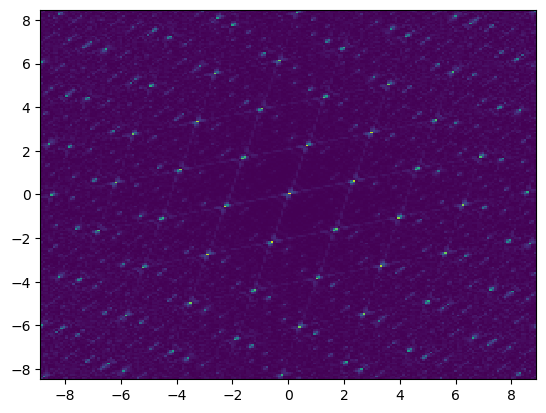

In [34]:
#plt.pcolormesh(xy_hist[1],xy_hist[2],nd.gaussian_filter(xy_hist[0],1))
plt.pcolormesh(xy_hist[1],xy_hist[2],np.abs(np.fft.fftshift(fft_hist)))
#plt.plot(coords[:,0],coords[:,1],'.')

In [35]:
1/dx

20.0

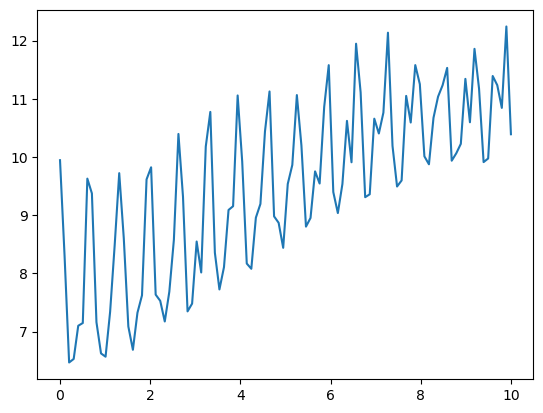

In [36]:
plt.plot(freq[:],(fft_x-0*nd.gaussian_filter(fft_x,1))[100:])
#plt.plot((fft_y-nd.gaussian_filter(fft_y,0.4))[100:])

In [3]:
import makefiguresandgraphics as mfag

mfag

Name of savefile: q


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/rafael/Documents/tissuewoundmodelling-main/SpringNetworkSimul/q.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
np.abs((np.array([-1,1])))

array([1, 1])

In [4]:
import makenetworkmovie as mnwm
#importlib.reload(mnwm)

Name of savefile: run1thermo
Starting frame: 0
Stopping frame: 5000
Frame step: 50
Image File Path: f
Do you want to make the movie now [y(1),n(0)]: 1
Stopping frame: 100
Video file name (with .mp4 included): netrunth1.mp4


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Name of savefile: run1thermo
Video file name (with .mp4 included): forcefieldthermo.mp4


KeyboardInterrupt: 

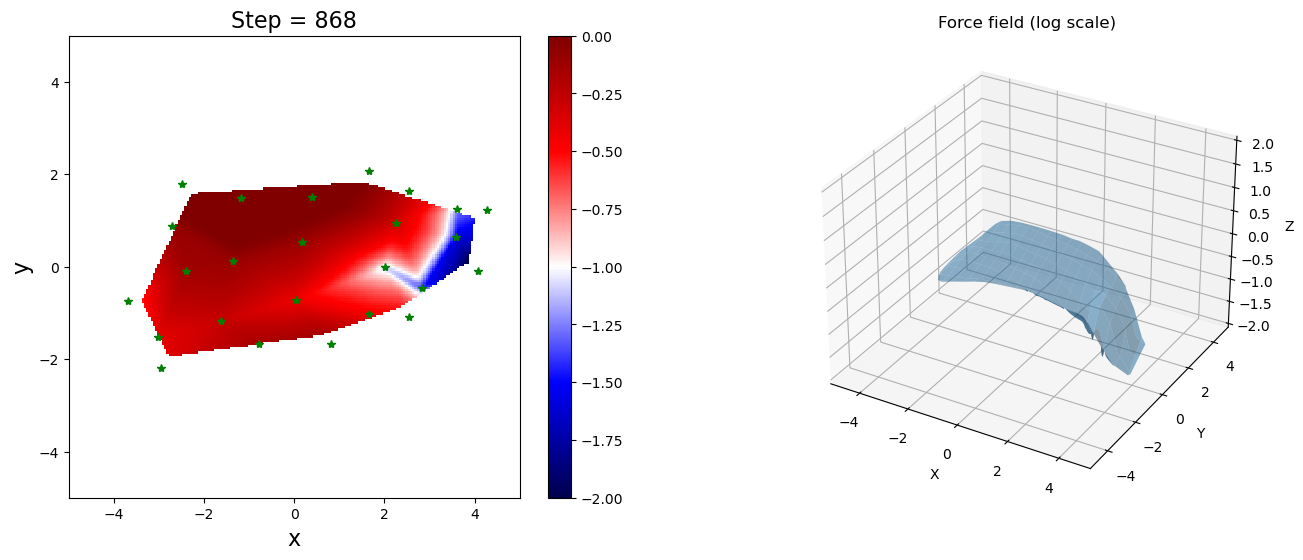

In [80]:
import movieforcefieldmovie as mffm
mffm

In [6]:
filename = input('Video file name (with .mp4 included): ')
img_array,size = mfp.loadframe(0,500,1,'f')
mfp.savevideo(img_array,filename,size,'f')

Video file name (with .mp4 included): thermalization_fft.mp4


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
